## Analyse de données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import datetime as dt

In [2]:
#import du fichier csv après nettoyage de données
data = pd.read_csv('data_p4_clean.csv')

In [3]:
# on change le format object de la colonne 'date' pour le format datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', errors= 'coerce')

# on ajoute une colonne pour avoir la date au format jj-mm-aaaa
data['date_2'] = pd.to_datetime(data['date'].dt.strftime('%Y%m%d'), errors= 'coerce')

# création de la colonne 'mois' pour pouvoir créer des graphiques périodiquement mensuels
data['mois'] = data['date'].apply(lambda x: x.strftime('%b %Y'))

# création d'une colonne précisant l'âge des clients
data['age'] = 2022- data['birth']

# création de tranches d'âges
cut_bins = [17, 29, 45, 59, 99]
cut_labels = ['18-29', '30-45', '46-59', '60+']
data['tranche'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels)

In [4]:
# classement des clients dans l'ordre décroissant de leur achat 
best_customers = data.groupby(['client_id']).sum().reset_index()[['client_id','price']].sort_values('price', ascending=False)
best_customers.rename(columns= {'price' : 'ca_par_client'}, inplace=True)

# ajout d'une colonne représentant les pourcentages cumulés
best_customers['cumul_%'] = 100*(best_customers['ca_par_client'].cumsum() / best_customers['ca_par_client'].sum())
best_customers

,client_id,ca_par_client,cumul_%
677,c_1609,162007.340000,2.794350
4388,c_4958,144257.210000,5.282541
6337,c_6714,73218.633656,6.545438
2724,c_3454,54464.213656,7.484853
7715,c_7959,2564.250000,7.529082
...,...,...,...
8151,c_8351,6.310000,99.999641
8480,c_890,6.080000,99.999746
750,c_1675,5.570000,99.999842
7889,c_8114,4.990000,99.999928


In [5]:
# la colonne type distingue les clients professionnels des clients particuliers
best_customers['type'] = ['professionnel' if s >= 5000 else 'particulier' for s in best_customers['ca_par_client']]
best_customers

,client_id,ca_par_client,cumul_%,type
677,c_1609,162007.340000,2.794350,professionnel
4388,c_4958,144257.210000,5.282541,professionnel
6337,c_6714,73218.633656,6.545438,professionnel
2724,c_3454,54464.213656,7.484853,professionnel
7715,c_7959,2564.250000,7.529082,particulier
...,...,...,...,...
8151,c_8351,6.310000,99.999641,particulier
8480,c_890,6.080000,99.999746,particulier
750,c_1675,5.570000,99.999842,particulier
7889,c_8114,4.990000,99.999928,particulier


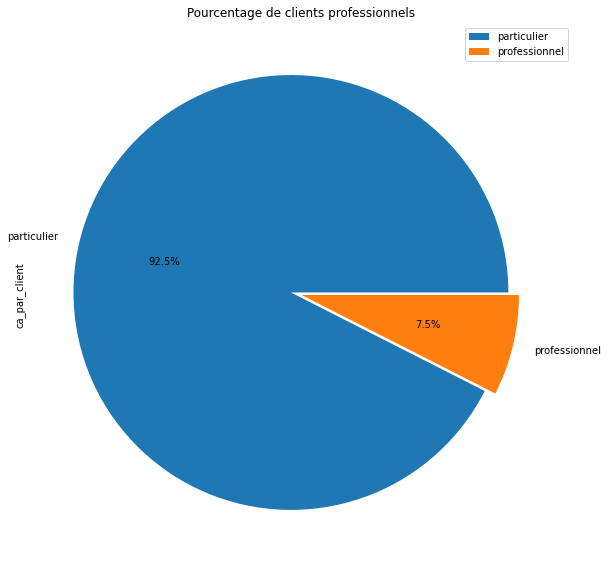

In [6]:
# réalisation d'un graphique circulaire
best_customers[['type', 'ca_par_client']].groupby(['type']).sum().plot(kind='pie', explode=(0.05, 0), subplots=True, figsize=(15,10), autopct='%1.1f%%')
plt.legend()
plt.title('Pourcentage de clients professionnels')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\clients_pro.jpg')

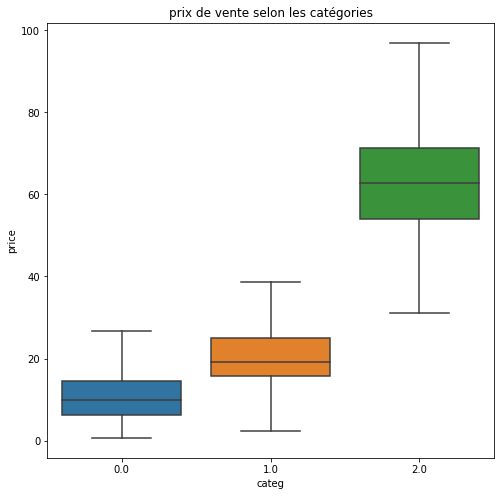

In [7]:
# réalisation d'un box-plot
plt.figure(figsize = (8,8))
axe = sns.boxplot(x= 'categ', y= 'price', data= data, showfliers=False)
plt.title('prix de vente selon les catégories')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\prix_vente_categories.jpg')
plt.show()

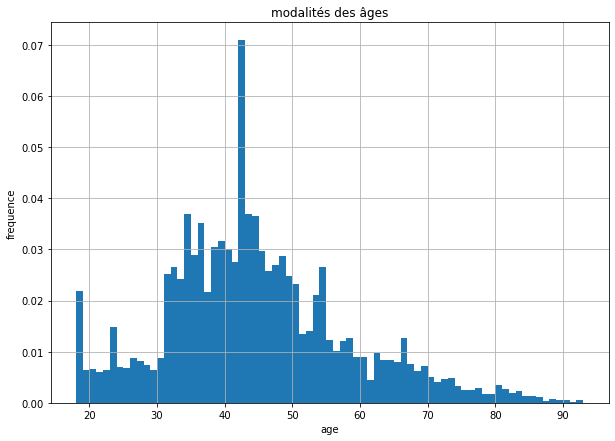

In [8]:
# graphique à barre représentant les modalités des âges
plt.figure(figsize= (10, 7))
data['age'].hist(alpha = 1, density= True, bins= 75)
plt.title('modalités des âges')
plt.xlabel('age')
plt.ylabel('frequence')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\modalites_ages.jpg')
plt.show()

In [9]:
effectif = data['categ'].value_counts()
modalites = effectif.index
table = pd.DataFrame(modalites, columns= ['categ'])
table['n']= effectif.values
table['f']= table['n'] / len(data)
table

,categ,n,f
0,0.0,209529,0.622087
1,1.0,109735,0.325801
2,2.0,17552,0.052112


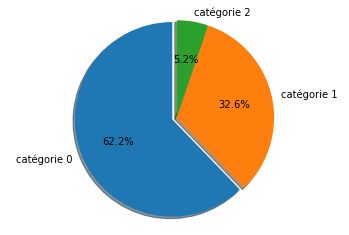

In [10]:
labels = 'catégorie 0', 'catégorie 1','catégorie 2'
sizes = table['f']
explode = (0.05, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle= 90)
ax1.axis('equal')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\poids_categ.jpg')

In [11]:
ca_mensuel = data.groupby(pd.Grouper(key= 'date', freq= 'M')).sum()
ca_mensuel = ca_mensuel.rename(columns={'price' : 'ca_mois'}).reset_index()
ca_mensuel = ca_mensuel[['date', 'ca_mois']]
ca_mensuel

,date,ca_mois
0,2021-03-31,479407.851454
1,2021-04-30,473129.775595
2,2021-05-31,489453.124626
3,2021-06-30,481332.467798
4,2021-07-31,480941.247313
5,2021-08-31,479401.011454
6,2021-09-30,502899.041939
7,2021-10-31,319234.487798
8,2021-11-30,512996.638282
9,2021-12-31,523012.207798


<Figure size 720x504 with 0 Axes>

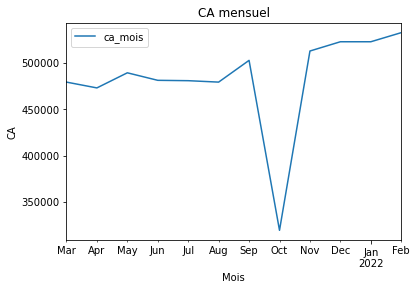

In [12]:
plt.figure(figsize= (10, 7))
ca_mensuel.plot(x= 'date', y= 'ca_mois')
plt.title('CA mensuel')
plt.xlabel('Mois')
plt.ylabel('CA')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\ca_mensuel.jpg')
plt.show()

### Mesures de tendance centrale et de dispersion

In [13]:
# calcul de la moyenne des prix des produits vendus
data['price'].mean()

17.21317987664951

In [14]:
## calcul de la médiane des prix des produits vendus
data['price'].median()

13.9

In [15]:
# calcul du mode des catégories
data['categ'].mode()

0    0.0
dtype: float64

In [16]:
# calcul de la variance empirique des prix
round(data['price'].var(ddof=0), 2)

318.73

In [17]:
# calcul de l'écart type empirique des prix
round(data['price'].std(ddof=0), 2)

17.85

### Mesures de concentration

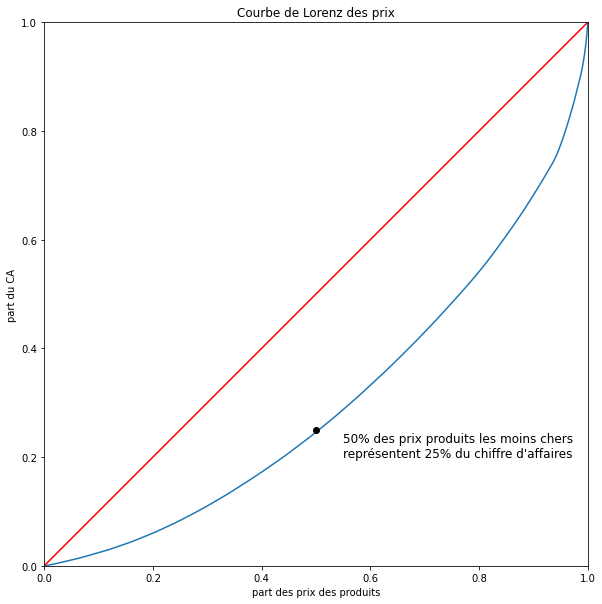

la valeur de l'indice de Gini est: 0.39


In [18]:
# courbe de Lorenz
prix = data['price'].values

lorenz = np.cumsum(np.sort(prix)) / prix.sum()
lorenz = np.append([0], lorenz)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0, 1, len(lorenz)), lorenz, drawstyle = 'steps-post')

plt.gca().set_aspect('equal', adjustable = 'box')
labels =['Courbe de concentration', 'Bissectrice']

x = [0, 1]
y = [0, 1]

plt.plot(x, y, 'red')
plt.ylabel('part du CA')
plt.xlabel('part des prix des produits')

plt.ylim(0, 1)
plt.xlim(0, 1)

plt.title('Courbe de Lorenz des prix')

plt.plot(0.5, 0.25, 'o', color= 'black')
plt.text(0.55, 0.2 , '50% des prix produits les moins chers\nreprésentent 25% du chiffre d\'affaires', fontsize = '12')

plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\courbe_de_Lorenz_price.jpg')
plt.show()

surface = lorenz[:-1].sum() / len(lorenz)

S = 0.5 - surface
gini = round(2*S, 2)
print('la valeur de l\'indice de Gini est:', gini)

In [19]:
# pivot table pour avoir le chiffre d'affaires journalier par catégories
df = data.pivot_table(values='price', index= 'date_2', columns= 'categ', aggfunc=sum)
df

categ,0.0,1.0,2.0
date_2,,,
2021-03-01,6270.306828,6811.53,3345.05
2021-03-02,6725.926828,5627.15,2995.04
2021-03-03,6112.060000,5691.41,2948.28
2021-03-04,5888.490000,6098.98,3059.62
2021-03-05,5969.990000,7071.21,4132.21
...,...,...,...
2022-02-24,7020.196828,6537.60,6642.57
2022-02-25,6403.663656,6452.78,5346.81
2022-02-26,7145.900000,7357.53,5256.15


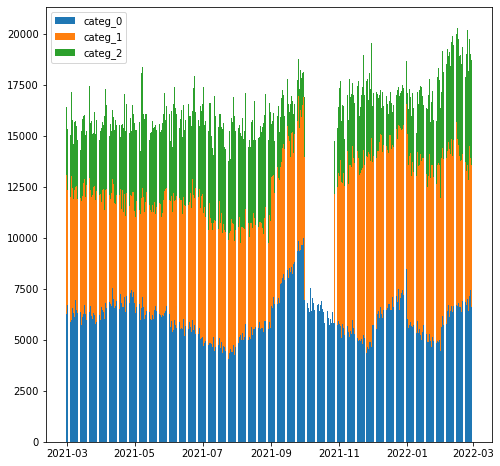

In [20]:
# réalisation d'un histogramme
fig = plt.figure(figsize = (8, 8))
ax= fig.add_subplot()
ax.bar(df.index, df.iloc[:, 0].values, label = 'categ_0')
ax.bar(df.index, df.iloc[:, 1].values, bottom = np.array(df.iloc[:, 0].values), label= 'categ_1')
ax.bar(df.index, df.iloc[:, 2].values, bottom = (np.array(df.iloc[:, 1].values) + np.array(df.iloc[:, 0].values)), label= 'categ_2')
plt.legend()
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\histogramme_ca_day.jpg')
plt.show()

## Corrélation entre le sexe des clients et les catégories de produits achetés

In [21]:
# représentation du tableau de contingence
cont = data[['sex', 'categ']].pivot_table(index= 'sex', columns= 'categ', aggfunc=len, margins=True, margins_name= 'total')
cont

categ,0.0,1.0,2.0,total
sex,,,,
f,103846,55469,8260,167575
m,105683,54266,9292,169241
total,209529,109735,17552,336816


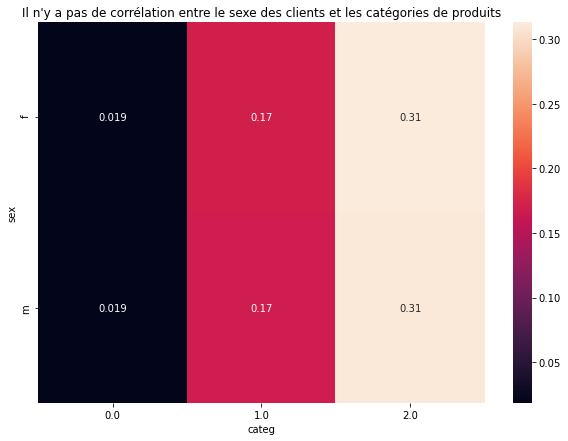

In [22]:
# tableau de contingence entre sexe et catégories
tx = cont.loc[:, ['total']]
ty = cont.loc[['total'], :]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c - indep)**2 / indep
xi_n = measure.sum().sum()
table = measure / xi_n
plt.figure(figsize = (10,7))
sns.heatmap(table.iloc[:-1, :-1], annot=True)
plt.title('Il n\'y a pas de corrélation entre le sexe des clients et les catégories de produits')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\tableau_contigence.jpg')
plt.close(fig)
plt.show()

In [23]:
# calcul du Chi-2
from scipy.stats import chi2_contingency
st_chi2, st_p, st_dof, st_exp = chi2_contingency(cont)

In [24]:
st_chi2

81.73335807676145

In [25]:
st_p

1.5659631165658027e-15

## Corrélation entre âge des clients et montant total des achats

In [26]:
df_age = data
df_age = df_age.groupby(by=['client_id', 'age']).sum()
df_age = df_age.reset_index()
df_age

,client_id,age,price,categ,birth
0,c_1,67,300.65,6.0,39100
1,c_10,66,586.18,19.0,54768
2,c_100,30,222.87,5.0,11952
3,c_1000,56,980.02,36.0,110096
4,c_1001,40,1102.45,16.0,114956
...,...,...,...,...,...
8595,c_995,67,119.08,3.0,15640
8596,c_996,52,739.60,25.0,82740
8597,c_997,28,572.89,19.0,45862
8598,c_998,21,1527.69,36.0,56028


In [27]:
pd.to_numeric(df_age['age'], errors='coerce')

0       67
1       66
2       30
3       56
4       40
        ..
8595    67
8596    52
8597    28
8598    21
8599    58
Name: age, Length: 8600, dtype: int64

NameError: name 'a' is not defined

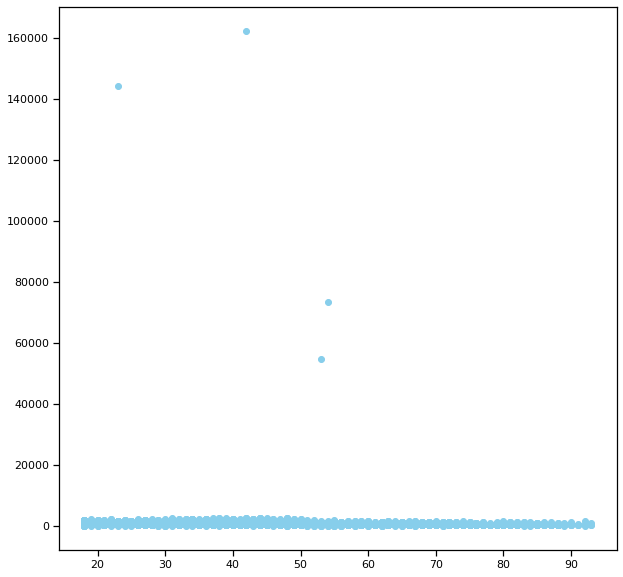

In [28]:
from scipy import stats

sns.set_context('notebook')
sns.set_palette('Set2')
plt.figure(figsize = (10,10))
plt.plot(df_age['age'],df_age['price'], "o", color='skyblue')
plt.plot(np.arange(18, 93),[a*x+b for x in np.arange(18,93)], color='r')
plt.ylim(0, 3000)
plt.xlabel("Age des clients")
plt.ylabel("Montant en euros")
plt.title('Montant total des achats en fonction de l\'âge')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\graphique_montant_total_achat_age.jpg')
plt.show()

In [ ]:
x = df_age['age']
y = df_age['price']

print('coefficient de pearson :', st.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df_age['price']
X = df_age[['age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['age'],result.params['intercept']
print('r-squared : ', (st.pearsonr(x,y)[0])**2)

## Corrélation entre l'âge des clients et la fréquence d’achat

In [ ]:
freq = data
freq['nb_achat'] = 1
freq = freq.groupby(['mois', 'age', 'session_id']).sum().reset_index()
freq['mois'] = pd.to_datetime(freq['mois']) 
freq = freq[['mois', 'age', 'nb_achat']]
freq = freq.sort_values(['mois', 'age'])
freq['freq_achat'] = freq['nb_achat']/freq['nb_achat'].sum()
freq.head()

In [ ]:
sns.set_context('notebook')
sns.set_palette('Set1')

plt.plot(figsize = (10,7))
plt.plot(freq['age'], freq['freq_achat'], "s", color='k')
plt.plot(np.arange(90),[a*x+b for x in np.arange(90)], color='r')
plt.xlabel("Age des clients")
plt.ylabel("Fréquences d'achats")
plt.title('Fréquence d\'achats mensuels en fonction de l\'âge')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\freq_achat_age.jpg')
plt.show()

In [ ]:
x = freq['age']
y = freq['freq_achat']

print('coefficient de pearson :', st.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = freq['freq_achat']
X = freq[['age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['age'],result.params['intercept']

print('r-squared : ', (st.pearsonr(x, y)[0])**2)

## Corrélation entre l'âge des clients et la taille du panier moyen (en nombre d'articles)

In [ ]:
pan = data.pivot_table(values= 'id_prod', index= ['client_id', 'session_id'], aggfunc= 'count').reset_index()
pan_x1 = pan[['client_id', 'id_prod']].groupby('client_id').mean()
pan_x1

In [ ]:
pan_x2 = data[['tranche', 'client_id']]
pan_x2 = pan_x2.drop_duplicates()
pan_x2

In [ ]:
pan_mean = pd.merge(pan_x1, pan_x2, on='client_id')

In [ ]:
pan_mean

In [ ]:
X = "tranche" # qualitative
Y = "id_prod" # quantitative

modalites = pan_mean[X].unique()
groupes = []
for m in modalites:
    groupes.append(pan_mean[pan_mean[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
 
plt.figure(figsize= (10, 7))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('nombre d\'articles')
plt.ylabel('tranche d\'âge')
plt.title('nombre d\'articles moyen selon les tranches d\'age')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\nbre_articles_tranche_age.jpg')
plt.show()

In [ ]:
X = pan_mean['tranche']
Y = pan_mean['id_prod']

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('eta-squared :', eta_squared(X,Y))

## Corrélation entre l'âge des clients et Les catégories de produits achetés

In [ ]:
sns.set_context('talk')
sns.set_palette('Set2')
plt.figure(figsize=[10,10])

sns.boxplot(x='categ', y='age', data=data, showfliers=False)
plt.ylabel('Age des clients')
plt.title('repartition de l\'âge selon les catégories')
plt.savefig(r'F:\dataAnalyst\Documentation projet\graphs livrable p4\repart_age_categ.jpg')
plt.show()

In [ ]:
X = data['categ']
Y = data['age']

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('eta-squared :', eta_squared(X,Y))